**2. Статистические критерии и АА-тесты. ЗАДАНИЯ.**

# Описание задачи

## Информация из предыдущих этапов

**Постановка кейса.**

В рамках практических заданий мы будем работать аналитиком на платформе по подаче объявлений. По результатам исследований мы выяснили, что недавно введенной функцией доставки пользуются редко. В рамках идей по исправлению ситуации была предложена инициатива выдать скидку в 20% на данную услугу, зачеркнув старую цену и написав рядом новую на карточках объявлений, в которых доступна доставка. Нам поставлена задача оценить данную инициативу.

## Текущее задание

**Метрики.**

По резульатам командного обсуждения было принято назначить целевой метрикой выручку. Прочие метрики, за которыми ваша команда планирует наблюдать: выручка с доставки, пользователи с доставкой, количество ошибок на экранах доставочный айтемов, количество заказов без доставки. Вам поручено провести предварительное исследование этих метрик на некотором срезе данных.

Суммарно можно получить более 10 баллов. Помимо непосредственно заданий есть скрытые баллы, которые можно получить, если писать хороший код и делать то, о чем говорилось на лекциях. При этом оценка будет рассчитываться из расчета, что 8.5 баллов - это 100% выполнения.

# Разведочный анализ. 1 балл

Проведите разведочный анализ данных.


*   Постройте распределение метрик, рассчитайте описательные статистики.
*   Есть ли в данных дубликаты, пропуски, отрицатлеьные значения, неправдоподбные выбросы?
*   Графики и статистики - ничто без интерпритации, выводов и рекоммендаций. Опишите словами выводы, которые вы планируете транслировать вашей команде относительно природы ваших данных.



In [1]:
import pandas as pd

df = pd.read_csv('task_2.csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            50000 non-null  int64  
 1   revenue            50000 non-null  float64
 2   delivery_revenue   50000 non-null  float64
 3   has_delivery       50000 non-null  bool   
 4   error_count        50000 non-null  int64  
 5   order_wo_delivery  50000 non-null  int64  
dtypes: bool(1), float64(2), int64(3)
memory usage: 2.0 MB
None


,user_id,revenue,delivery_revenue,has_delivery,error_count,order_wo_delivery
0,5488135039,0.0,0.0,False,0,1
1,7151893663,0.0,0.0,False,0,1
2,6027633760,0.0,0.0,False,0,6
3,5448831829,0.0,0.0,False,0,3
4,4236547993,0.0,0.0,False,0,9


In [2]:
print("Всего дубликатов: ", df.duplicated().sum())
print("Дубликатов user_id: ", df.duplicated(subset=['user_id']).sum())

Всего дубликатов:  0
Дубликатов user_id:  0


In [3]:
numerical_columns = ['revenue', 'delivery_revenue', 'error_count', 'order_wo_delivery']
metric_columns = numerical_columns + ['has_delivery']

print(df[metric_columns].describe())

            revenue  delivery_revenue  error_count  order_wo_delivery
count  50000.000000      50000.000000  50000.00000       50000.000000
mean      92.015884         28.945820      0.10382           2.325540
std      416.208923        239.845266      1.42711           2.783824
min        0.000000          0.000000      0.00000           0.000000
25%        0.000000          0.000000      0.00000           0.000000
50%        0.000000          0.000000      0.00000           1.000000
75%        0.000000          0.000000      0.00000           3.000000
max     8380.058857       8347.164035     77.00000          27.000000


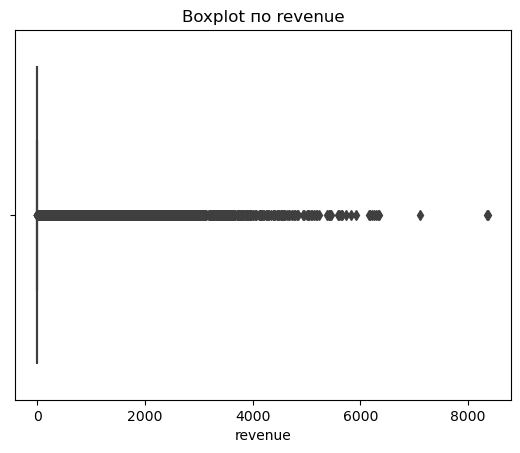

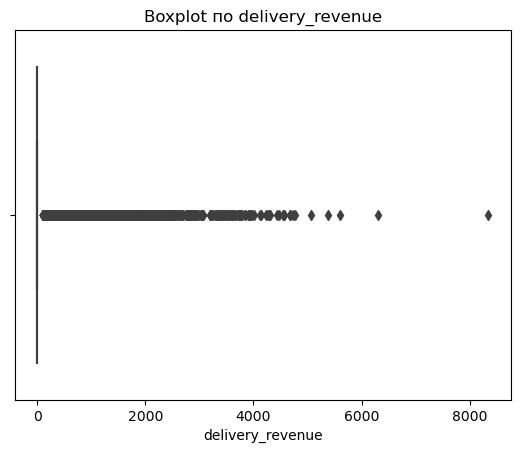

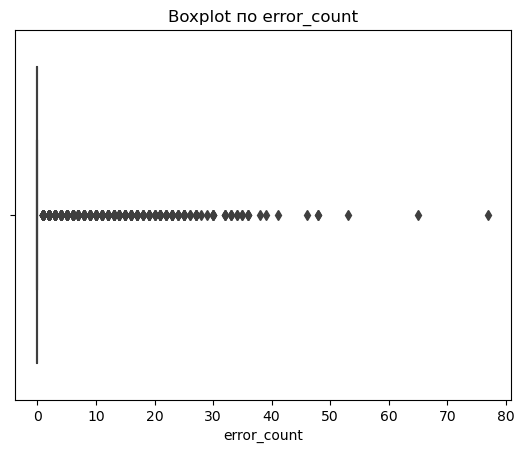

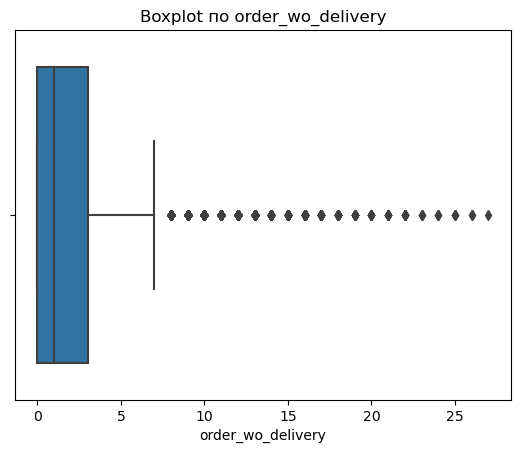

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

numerical_columns = ['revenue', 'delivery_revenue', 'error_count', 'order_wo_delivery']

for col in numerical_columns:
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot по {col}')
    plt.show()

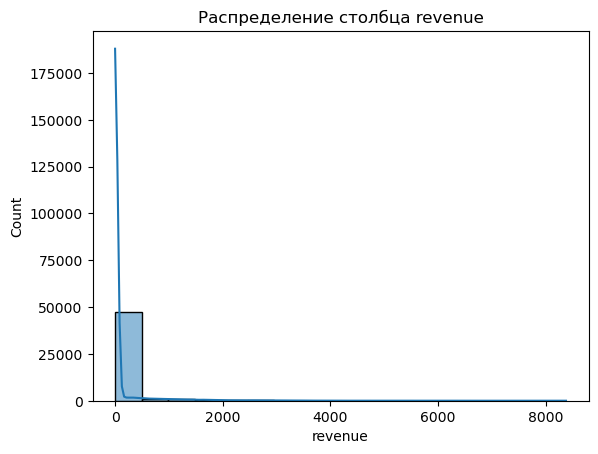

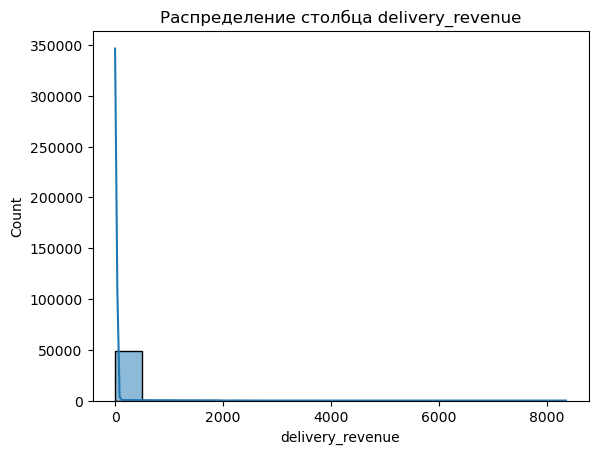

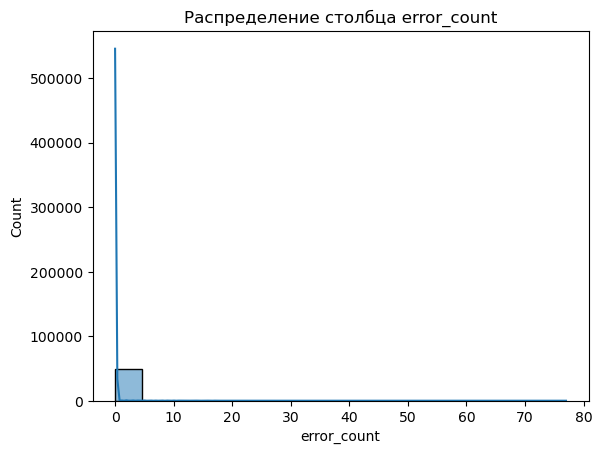

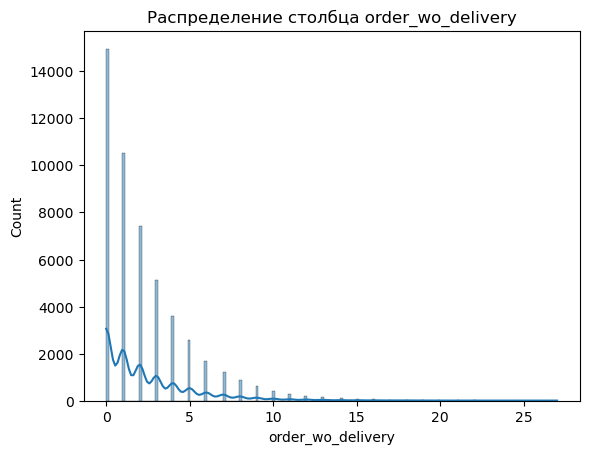

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


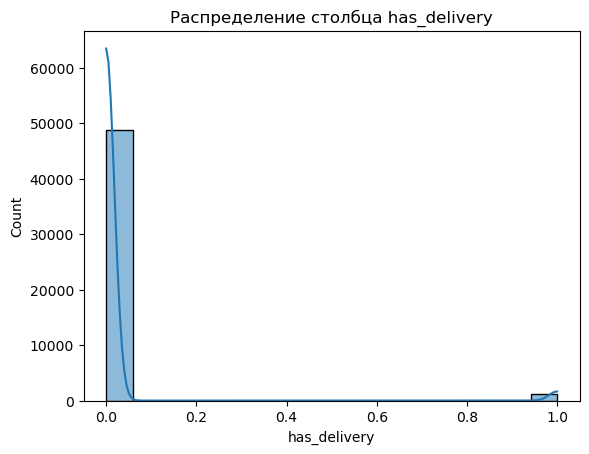

In [5]:
for col in metric_columns:
    sns.histplot(df[col], kde=True)
    plt.title(f'Распределение столбца {col}')
    plt.show()

### Выводы
- По итогам предварительного анализа выяснилось, что в данных нет проблемных значений (пропусков, дубликатов или странных выбросов)
- Метрики распределены экспоненциально кроме order_wo_delivery и has_delivery
- Особенностью столбца order_wo_delivery является то, что значения в нём дискретные и не превышают 27.
- В has_delivery большинство значений -- 0

# Реализация теста Стьюдента и бутстрапа. 2 балла

*   Реализуйте свои версии тестов Стьюдента и Бутстрапа.
*   Прокомментируйте код ваших функций с помощью #.
*   Сравните результат обеих функций. При больших n p-value, полученное с помощью обоих методов не должно сильно отличаться. В качестве контроля возьмите первые 25 тысяч строк метрики order_wo_delivery, а в качестве тест - вторые 25 тысяч.

Разумеется, вызывать библиотечные функции тестов нельзя - необходимо реализовать свои с помощью numpy, scipy etc. Будем считать, что тесты должны быть двусторонними. P-value в бутстрапе можно считать на основании положения нуля.

In [6]:
def calc_my_t_test(control, test):
    import numpy as np
    from scipy.stats import t

    # Считаем части формулы t-статистики
    avg_control = np.mean(control)
    avg_test = np.mean(test)
    
    var_control = np.var(control, ddof=1)  # ddof=1 для несмещенной оценки
    var_test = np.var(test, ddof=1)
    
    # Проверка на нулевую дисперсию
    if var_control == 0 or var_test == 0:
        return np.nan
    
    n_control = len(control)
    n_test = len(test)
    
    t_statistic = (avg_control - avg_test) / np.sqrt(var_control / n_control + var_test / n_test)
    
    # Считаем степени свободы
    df = n_control + n_test - 2
    
    # Считаем p-value (двусторонний тест)
    p_value = 2 * (1 - t.cdf(abs(t_statistic), df)) #Используем cdf чтобы не вытаскивать табличные значения функции
    
    return p_value

In [7]:
def calc_my_bootstrap(control, test, func, n_boot=10_000):
    import numpy as np
    
    # Объединяем данные в одну выборку
    pool = np.concatenate([control, test])
    n_control = len(control)
    n_test = len(test)
    
    # Наблюдаемое значение статистики
    observed_stat = func(control, test)
    
    # Массив для хранения бутстрап-статистик
    bootstrap_stats = np.zeros(n_boot)
    
    # Бутстрап-итерации
    for i in range(n_boot):
        # Случайное выборка с заменой из общей выборки
        bootstrap_control = np.random.choice(pool, size=n_control, replace=True)
        bootstrap_test = np.random.choice(pool, size=n_test, replace=True)
        
        # Вычисляем статистику для новой выборки
        bootstrap_stats[i] = func(bootstrap_control, bootstrap_test)
    
    # Вычисляем p-value
    p_value = np.mean(bootstrap_stats >= observed_stat)
    
    return p_value

In [8]:
# пример func
def calc_mean_diff(control, test):
  mean_diff = test.mean() - control.mean()
  return mean_diff

In [9]:
control = df['order_wo_delivery'].loc[:25000]
test = df['order_wo_delivery'].loc[25000:]

In [10]:
calc_my_t_test(control, test)

0.35286159340501344

In [11]:
calc_my_bootstrap(control, test, calc_mean_diff)

0.1743

# Валидация теста Стьюдента. 3 балла

Мы бы хотели исопльзовать тест Стьюдента, исходя из знаний, полученных на лекции. Однако не все коллеги аналитики согласны с тем, что данный тест можно применять на данных, которые распределены НЕнормально. К тому же, мы знаем, что критерии необходимо валидировать. Проведите следующее исследование:


*   Заведите цикл, в котором 10 тысяч раз данные разбиваются на тест и контроль 50 на 50. Каждый раз сохраняйте p-value из теста Стьюдента. На выходе у вас должен получиться 5 массивов по 10 тыся p-value для каждой метрики. Можете воспользоваться train_test_split из sklearn.
*   Рассчитайте для каждой метрики реальный уровень ошибки 1 рода при alpha = 0.05 и доверительный интервал для этого показателя с помощью proportion_confint (см. видео 17).
*   Для каждого p-value постройте гистограмму распредления занчений. Проверьте принадлежность этих распределений к семейству равномерных с помощью критерия Колмагорова-Смирнвоа (kstest).

Выполнение инструкций гарантирует только половину баллов. Еще половина - это ваши комментарии, интеритации и выводы на основе полученных данных.



Метрика: revenue
Уровень ошибки 1 рода: 0.0483
Доверительный интервал: (0.04409784864419049, 0.05250215135580952)

Метрика: delivery_revenue
Уровень ошибки 1 рода: 0.0474
Доверительный интервал: (0.04323521534673257, 0.05156478465326743)

Метрика: error_count
Уровень ошибки 1 рода: 0.0526
Доверительный интервал: (0.048224701846025037, 0.056975298153974965)

Метрика: order_wo_delivery
Уровень ошибки 1 рода: 0.0519
Доверительный интервал: (0.04755230726821668, 0.05624769273178332)

Метрика: has_delivery
Уровень ошибки 1 рода: 0.0524
Доверительный интервал: (0.048032566906833454, 0.05676743309316655)



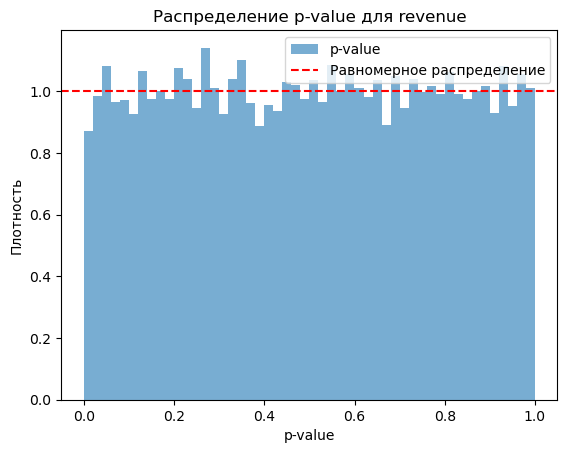

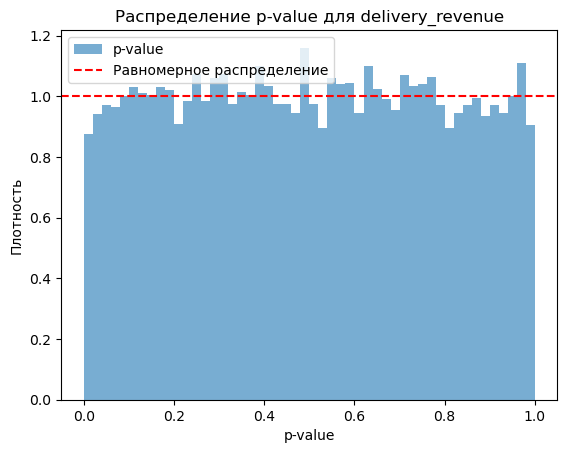

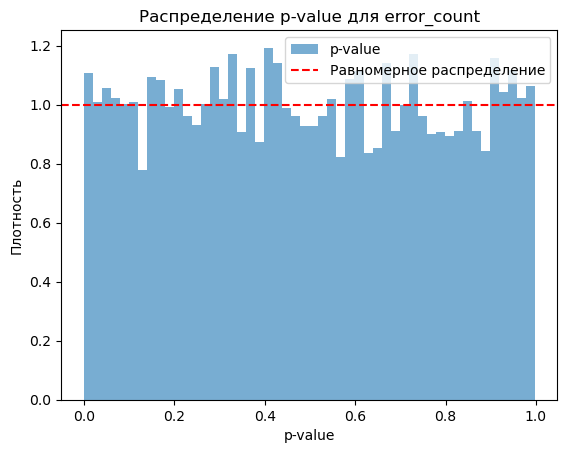

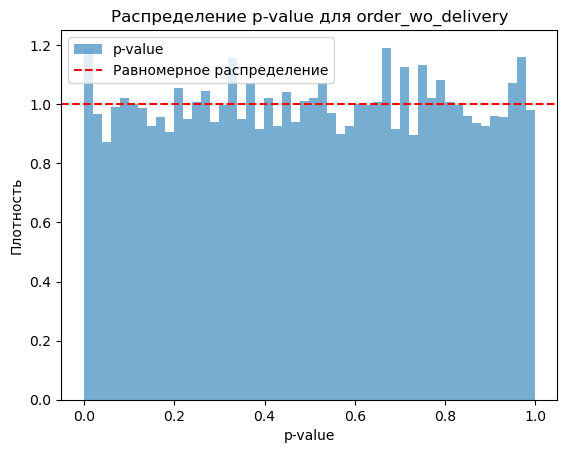

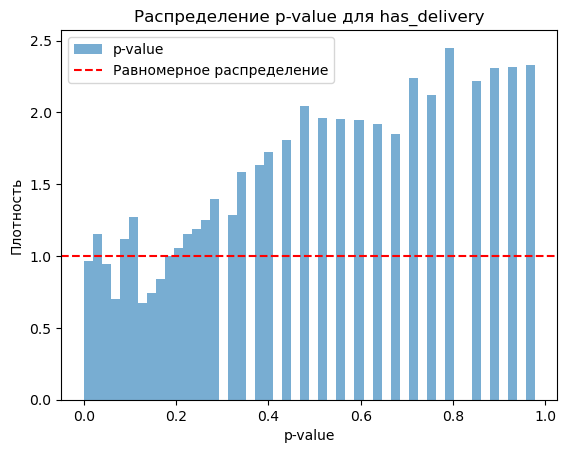

Метрика: revenue
K-S статистика: 0.005250352259476371, p-value: 0.9442712408935915
Распределение p-value соответствует равномерному.

Метрика: delivery_revenue
K-S статистика: 0.007988092543155578, p-value: 0.543378441893852
Распределение p-value соответствует равномерному.

Метрика: error_count
K-S статистика: 0.015297501016308446, p-value: 0.018362184129323
Распределение p-value НЕ соответствует равномерному.

Метрика: order_wo_delivery
K-S статистика: 0.007353049412085255, p-value: 0.6491401458419999
Распределение p-value соответствует равномерному.

Метрика: has_delivery
K-S статистика: 0.02619271332479134, p-value: 2.1559684704439918e-06
Распределение p-value НЕ соответствует равномерному.



In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind, kstest
from statsmodels.stats.proportion import proportion_confint
import matplotlib.pyplot as plt

n_iter = 10_000
alpha = 0.05
n_metrics = len(metric_columns)

# Массивы для хранения p-value
p_values = {metric: np.zeros(n_iter) for metric in metric_columns}

# Цикл для разбиения данных и вычисления p-value
for i in range(n_iter):
    for metric in df[metric_columns].columns:
        # Разбиваем данные на тест и контроль напополам
        control, test = train_test_split(df[metric], test_size=0.5, random_state=i)
        
        # Вычисляем p-value с помощью своего t-теста Стьюдента
        p_value = calc_my_t_test(control, test)
        p_values[metric][i] = p_value

# Создадим словари для оценок ошибки 1 рода и доверительных интервалов
type_1_errors = {}
conf_intervals = {}

for metric in p_values:
    # Уровень ошибки 1 рода (доля p-value < alpha)
    type_1_error = np.mean(p_values[metric] < alpha)
    type_1_errors[metric] = type_1_error
    
    # Доверительный интервал для уровня ошибки 1 рода
    conf_interval = proportion_confint(count=type_1_error * n_iter, nobs=n_iter, alpha=0.05)
    conf_intervals[metric] = conf_interval

for metric in type_1_errors:
    print(f"Метрика: {metric}")
    print(f"Уровень ошибки 1 рода: {type_1_errors[metric]:.4f}")
    print(f"Доверительный интервал: {conf_intervals[metric]}")
    print()

# Посмотрим на распределение p-value
for metric in p_values:
    plt.figure()
    plt.hist(p_values[metric], bins=50, density=True, alpha=0.6, label='p-value')
    plt.title(f'Распределение p-value для {metric}')
    plt.xlabel('p-value')
    plt.ylabel('Плотность')
    plt.axhline(1, color='r', linestyle='--', label='Равномерное распределение')
    plt.legend()
    plt.show()

# Проверим равномерность распределения p-value с помощью критерия Колмогорова-Смирнова
for metric in p_values:
    ks_statistic, ks_p_value = kstest(p_values[metric], 'uniform')
    print(f"Метрика: {metric}")
    print(f"K-S статистика: {ks_statistic}, p-value: {ks_p_value}")
    if ks_p_value > 0.05:
        print("Распределение p-value соответствует равномерному.")
    else:
        print("Распределение p-value НЕ соответствует равномерному.")
    print()

### Выводы
Провалидировав t-test, можно сказать, что он применим для ситуаций, когда данные распределены не нормально. Однако, возникает проблема в столбце has_delivery - p-value для него не распределено нормально для 10000 итераций, хотя мы

# Валидация бутстрапа. 0.5 балла


Попробуйте проделать аналогичное исследование для бутстрапа. С какой проблемой вы столкнулись?

Итераций вычислений будет слишком много, так как в самом бутстрапе у нас 10000 итераций по стандарту, и в функции проверки тоже 10000 итераций. При уменьшении количества итераций мы можем не дойти до момента, когда ЦПТ начнёт выполняться для наших метрик. Скорее всего, бутстрап может не сойтись на меньших значениях, плюс, у нас будет слишком много мелких выборок.

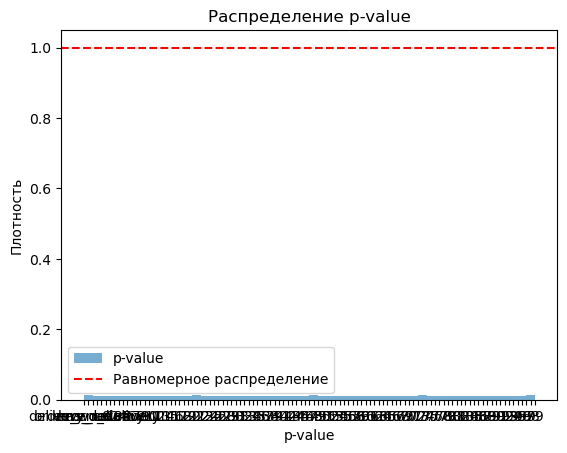

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.stats import kstest
from statsmodels.stats.proportion import proportion_confint
import matplotlib.pyplot as plt

n_iter = 100
alpha = 0.05

p_values = {metric: np.zeros(n_iter) for metric in metric_columns}

# Цикл для разбиения данных и вычисления p-value
for i in range(n_iter):
    for metric in df[metric_columns].columns:
        # Разбиваем данные на тест и контроль напополам
        control, test = train_test_split(df[metric], test_size=0.5, random_state=i)

        # Вычисляем p-value с помощью бутстрапа
        p_value = calc_my_bootstrap(control, test, calc_mean_diff, n_boot=100)
        p_values[i] = p_value

for metric in p_values:
    # Уровень ошибки 1 рода (доля p-value < alpha)
    type_1_error = np.mean(p_values[metric] < alpha)
    type_1_errors[metric] = type_1_error
    
    # Доверительный интервал для уровня ошибки 1 рода
    conf_interval = proportion_confint(count=type_1_error * n_iter, nobs=n_iter, alpha=0.05)
    conf_intervals[metric] = conf_interval        

# Посмотрим на распределение p-value
plt.figure()
plt.hist(p_values, bins=50, density=True, alpha=0.6, label='p-value')
plt.title('Распределение p-value')
plt.xlabel('p-value')
plt.ylabel('Плотность')
plt.axhline(1, color='r', linestyle='--', label='Равномерное распределение')
plt.legend()
plt.show()

# Сходимость теста Стьюдента. 2 балла

Проведите дополнительное исследование, с помощью которого можно будет ответить на вопрос: с какого количества наблюдений мы получаем корректные результаты для t-test'a?
Для этого возьмите случайную подвыборку данных (без повторений) размера n и посмотрите на ошибку 1 рода для такого n. Ошибаемся ли мы в 5% случаев при n = 10 в каждой группе? А при n = 1000? Где примерно находится переломный момент? Различен ли он для разных метрик в нашем тесте? Постройте график зависимости ошибки 1 рода от количества наблюдений в каждой из групп. Не забывайте про комментарии, интерпритацию и выводы.

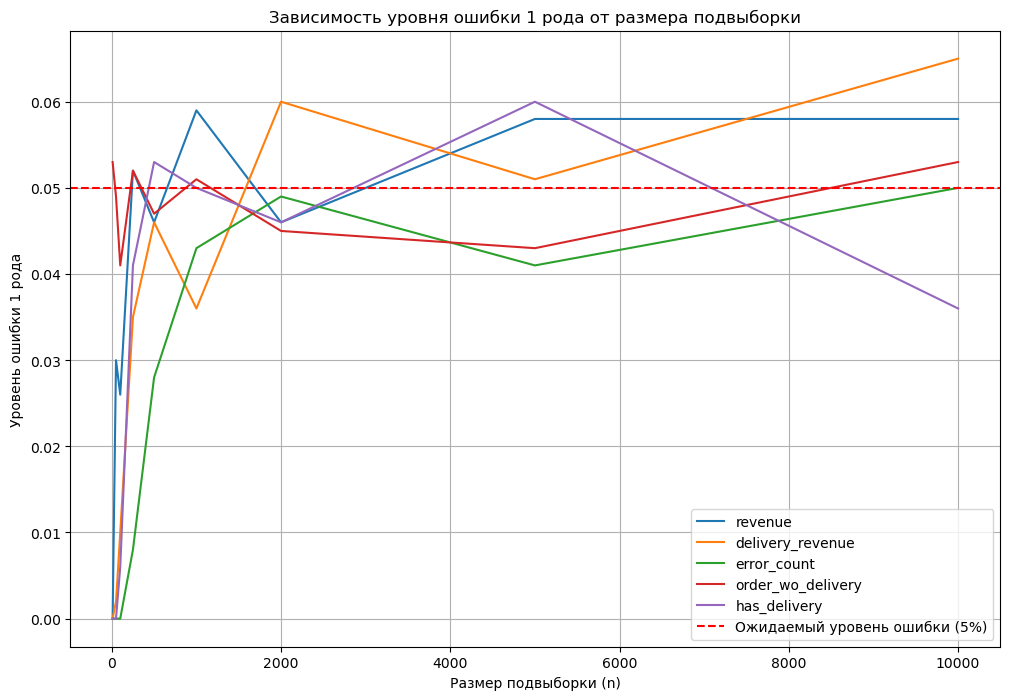

In [17]:
n_iter = 1000
alpha = 0.05
sample_sizes = [10, 50, 100, 250, 500, 1000, 2000, 5000, 10000]  # Размеры подвыборок от 10 до 1000 с шагом 10

type_1_errors = {metric: np.zeros(len(sample_sizes)) for metric in metric_columns}

# Цикл по размерам подвыборок
for idx, n in enumerate(sample_sizes):
    
    # Цикл по метрикам
    for metric in metric_columns:
        p_values = np.zeros(n_iter)
        
        # Цикл итераций для оценки уровня ошибки 1 рода
        for i in range(n_iter):
            sample = df[metric].sample(n=n * 2, replace=False, random_state=i)
            control, test = train_test_split(sample, test_size=0.5, random_state=i)

            # Вычисленим p-value с помощью t-теста
            p_value = calc_my_t_test(control, test)
            p_values[i] = p_value
        
        # Оценка уровня ошибки 1 рода
        type_1_errors[metric][idx] = np.mean(p_values < alpha)

plt.figure(figsize=(12, 8))
for metric in metric_columns:
    plt.plot(sample_sizes, type_1_errors[metric], label=metric)

plt.axhline(alpha, color='r', linestyle='--', label='Ожидаемый уровень ошибки (5%)')
plt.xlabel('Размер подвыборки (n)')
plt.ylabel('Уровень ошибки 1 рода')
plt.title('Зависимость уровня ошибки 1 рода от размера подвыборки')
plt.legend()
plt.grid()
plt.show()

### Выводы
Переломный момент находится примерно около 1000